In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import time

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


step onte : 读入图片

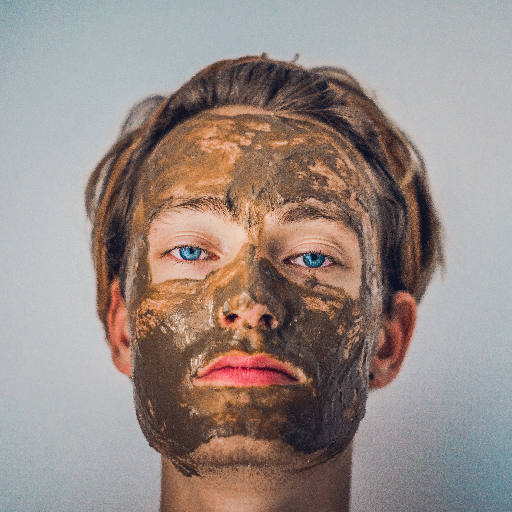

In [2]:
height = 512
width  = 512

#路径
content_image_path = 'images/isabell.jpg'
content_image = Image.open(content_image_path)

#重塑图片大小
content_image = content_image.resize((width,height))
content_image

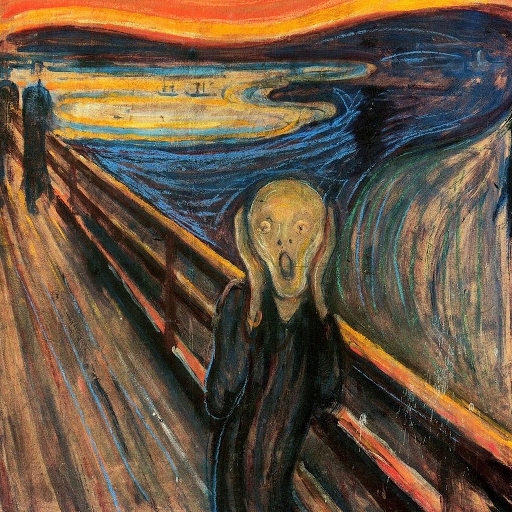

In [3]:
#读入风格图片
style_image_path = 'images/styles/scream.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width,height))
style_image

In [4]:
#数据格式转换
content_array = np.asanyarray(content_image,dtype = np.float32)
style_array = np.asanyarray(style_image,dtype = np.float32)

#图片的大小
print(content_array.shape)
print(style_array.shape)

(512, 512, 3)
(512, 512, 3)


In [5]:
#扩展数组维度
content_array = np.expand_dims(content_array,axis=0)
style_array = np.expand_dims(style_array,axis=0)

print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [6]:
#为了配合VGG net 的模型输入，我们对两张input image 做一下变换，
#具体操作是：1.去均值   2.调换一下channel的顺序
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [7]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder(shape=(1,width,height,3),dtype=np.float32)#然后 我们把三个图片都concate在一起

In [8]:
input_image = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

然后 我们把三个图片都concate在一起

## 第二步：调用pretrain的VGG16完成我们的工作

课上讲过，VGG是在图片分类任务中被训练出来的，我们感兴趣的就是它把图片处理成『数字化的表达形式』的功能。

![VGG Network Architectures](images/vgg-architecture.png "VGG Network Architectures")

调用VGG16以后，它会自动下载fchollet的VGG16的weights

In [9]:
model = VGG16(input_tensor=input_image, weights='imagenet',
              include_top=False)

In [10]:
layers = dict([(layer.name,layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

# 优化

课上讲过，我们这里用三个损失方程来优化我们的图片：

*content loss*

*style loss*

*total variation loss*

我们给三个loss先附上权值

In [11]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [12]:
loss = backend.variable(0.)

content loss

In [13]:
def content_loss(content,combination):
    return backend.sum(backend.square(content_images_features-combination_image_features))

content_layers_features = layers[ 'block2_conv2']
content_images_features = content_layers_features[0,:,:,:]
combination_image_features = content_layers_features[2,:,:,:]

style loss

In [14]:
layers_to_compute = ['block1_conv2', 'block2_conv2',
              'block3_conv3', 'block4_conv3',
              'block5_conv3']

def gram_matrix(x):
    Fl = backend.reshape(backend.permute_dimensions(x,(2,0,1)),[int(x.shape[2]),-1])
    gram = backend.dot(Fl,backend.transpose(Fl))
    return gram

def style_loss(layers,layers_to_compute):
    style_loss = 0
    for layer_name in layers_to_compute:
        layers_features = layers[layer_name]
        style_image_features = layers_features[1,:,:,:]
        combination_image_features = layers_features[2,:,:,:]
        Ml = height * width
        Nl = 3
        S = gram_matrix(style_image_features)
        C = gram_matrix(combination_image_features)
        sl = backend.sum(backend.square(S-C))/(4.*(Ml**2)*(Nl**2))
        style_loss += sl
    return style_loss
        

In [15]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

In [16]:
loss += content_weight * content_loss(content_images_features,combination_image_features) + style_weight * style_loss(layers,layers_to_compute)+ total_variation_weight * total_variation_loss(combination_image)

## 用Gradients解决Optimisation问题

一个是loss，一个是我们的合成图片

In [17]:
grads = backend.gradients(loss, combination_image)

In [18]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image],outputs)

def eval_loss_and_grads(x):
    #print('x_shape',x.shape)
    x = x.reshape((1,width,height,3))
    output = f_outputs([x])
    loss = output[0]
    grads= output[1].flatten().astype('float64')
    return loss,grads

class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grads_value= None
    
    def loss(self,x):
        assert self.loss_value is None
        loss_val,grads_val = eval_loss_and_grads(x)
        self.loss_value = loss_val
        self.grads_value=grads_val
        return self.loss_value
    
    def grads(self,x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value= None
        return grad_values
evaluator = Evaluator()

In [19]:
#生成一副随机白噪声图像用于训练
x = np.random.uniform(0,255,(1,width,height,3))-128
#Image.fromarray(x)
x.shape

(1, 512, 512, 3)

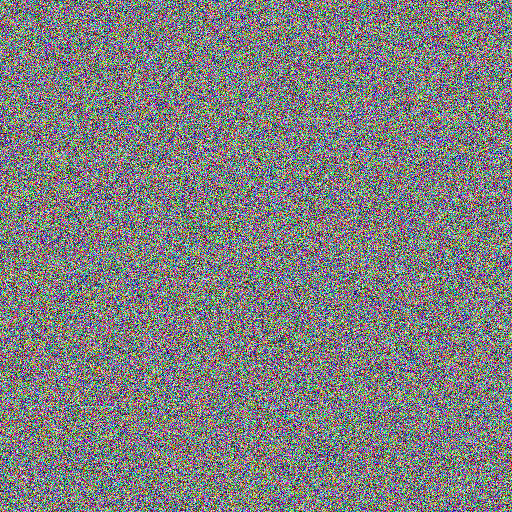

In [20]:
Image.fromarray(x.reshape((width,height,3)).astype('uint8'))

In [21]:
x.shape

(1, 512, 512, 3)

In [22]:
iteration = 200

for i in range(iteration):
    print('from iteration {}'.format(i))
    start_time = time.time()
    x,min_val,info = fmin_l_bfgs_b(evaluator.loss,x,fprime=evaluator.grads,maxfun=20)
    end_time = time.time()
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


from iteration 0
Current loss value: 7.98405e+12
Iteration 0 completed in 8s
from iteration 1
Current loss value: 6.53022e+12
Iteration 1 completed in 4s
from iteration 2
Current loss value: 5.31114e+12
Iteration 2 completed in 7s
from iteration 3
Current loss value: 4.33836e+12
Iteration 3 completed in 4s
from iteration 4
Current loss value: 3.55917e+12
Iteration 4 completed in 8s
from iteration 5
Current loss value: 2.93748e+12
Iteration 5 completed in 9s
from iteration 6
Current loss value: 2.45247e+12
Iteration 6 completed in 6s
from iteration 7
Current loss value: 2.07374e+12
Iteration 7 completed in 7s
from iteration 8
Current loss value: 1.78665e+12
Iteration 8 completed in 7s
from iteration 9
Current loss value: 1.57491e+12
Iteration 9 completed in 7s
from iteration 10
Current loss value: 1.41474e+12
Iteration 10 completed in 6s
from iteration 11
Current loss value: 1.29152e+12
Iteration 11 completed in 8s
from iteration 12
Current loss value: 1.19885e+12
Iteration 12 completed

Current loss value: 5.37701e+10
Iteration 104 completed in 8s
from iteration 105
Current loss value: 5.33883e+10
Iteration 105 completed in 7s
from iteration 106
Current loss value: 5.30867e+10
Iteration 106 completed in 9s
from iteration 107
Current loss value: 5.29252e+10
Iteration 107 completed in 8s
from iteration 108
Current loss value: 5.28074e+10
Iteration 108 completed in 7s
from iteration 109
Current loss value: 5.25385e+10
Iteration 109 completed in 8s
from iteration 110
Current loss value: 5.24768e+10
Iteration 110 completed in 10s
from iteration 111
Current loss value: 5.2393e+10
Iteration 111 completed in 10s
from iteration 112
Current loss value: 5.23589e+10
Iteration 112 completed in 3s
from iteration 113
Current loss value: 5.22371e+10
Iteration 113 completed in 8s
from iteration 114
Current loss value: 5.10331e+10
Iteration 114 completed in 10s
from iteration 115
Current loss value: 4.89941e+10
Iteration 115 completed in 8s
from iteration 116
Current loss value: 4.8775

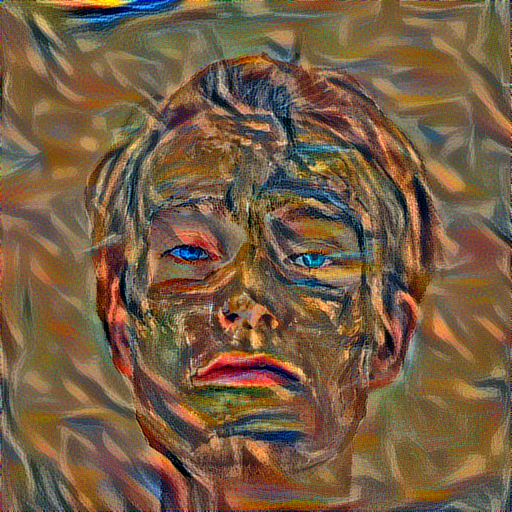

In [23]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)
